## Leaky integrated firing neuron model  
## Few feautures :
### Spatial network, no memory term but exponential decay of cumulative dose

This is a minor change of the Dodds and Watts model  
Attempt to implement adaptive rewiring

In [67]:
#importing the required libraries

import networkx as nx #network library to generate inital networks and perform various network operations
from matplotlib import animation
import matplotlib.pyplot as plt #for plotting
import numpy as np #for using arrays and vectorising the code wherever possible
import scipy
import random
import cProfile #for timing the loops
from numba import jit #numba precomplier to make the code faster
import pandas as pd
import time
import copy
# %matplotlib notebook
# %matplotlib notebook

# Variables used in the simulation

In [68]:
dataset = 12

N = 100
gamma = 1 #decay of cumulative dose per unit time (second)
T = 100 #total number of seconds
dt = 0.05 #seconds
'''number of simulation steps is T/dt'''

'''Dodds watts parameters'''
p = 1 #rate of dose transfer (per unit time (second))
p = p*dt #rate of dose transfer per unit simulation step
r = 1/dt
r = r*dt
rho = 1/dt
rho = rho*dt

d_star = 1
dose_quantity = 0.1
D_ini = 3

'''network parameters'''
circ_rad = 100 #for a network in which each node is connected to other nodes withing a circle of radius circ_rad
nn = 7 #the number of nearest neighbours(i.e. k) in knn
average_degree = 6
total_edges = N*2

'''rewiring parameters'''
p_rew = 10 #rate of rewiring(per unit time(second))
lamb_da = p_rew/10
lamb_da = lamb_da*dt
p_rew = p_rew*dt
w_minus = 1
w_minus = w_minus*dt

'''number of infected nodes initially'''
start = 1

# Creating the network. 
### The network outputs coordinates, distance matrix, edge_list and adjacency matrix

In [69]:
'''
obtains the number of nodes N
generates N points
calculates euclidean distance between each pair of points
returns the coordinates of the points and the distance matrix which is N*N
'''
def calc_dist(N) :
    coords = []
    for counter in range(N) :
        coords.append((N*np.random.random(),N*np.random.random()))

    dist_mat = scipy.spatial.distance.cdist(coords,coords)
    return dist_mat,coords

### 1. metric network

In [70]:
'''network = connect to points withing a circle of radius'''
#creates a link between points/nodes which satisfies the conditions of the network
def coupling(dist_mat,circ_rad) :
    edge_list = []
    edge_mask = (dist_mat<circ_rad) & (dist_mat>0)
    edge_list.extend(np.ndarray.tolist(np.transpose(np.where(edge_mask))))
#     print(type(np.ndarray.tolist(np.transpose(np.where(edge_mask)))))
    return edge_list

### 2. K nearest neighbour network

In [71]:
'''network = knn'''
def knn(dist_mat,nn,N) :
    near_neigh = np.argsort(dist_mat)
    selec_near_neigh = np.zeros((N,nn))
    selec_near_neigh = near_neigh[:,0:nn+1]

    edge_list = []
    for i in range(N) :
        for j in range(1,nn+1) :
            link = [i,selec_near_neigh[i,j]]
            edge_list.append(link)

    return edge_list

### 3. Random Network : GNP type

In [72]:
'''random network'''
def rand_network(average_degree,N) :
    z1 = np.random.uniform(size = (N,N))
    E,F = np.meshgrid(np.arange(0,N),np.arange(0,N))
    mask = ((average_degree/N) > z1) & (E!=F)
    adjacency_matrix = np.int64(np.zeros(shape=(N,N)))
    adjacency_matrix[mask] = np.int64(1)
    edge_list = []
    edge_list.extend(np.ndarray.tolist(np.transpose(np.where(adjacency_matrix==1))))
    return edge_list,adjacency_matrix

### 4. Random Network : GNM type

In [73]:
def rand_net_gnm(total_edges,N) :
    the_graph = nx.gnm_random_graph(N, total_edges,directed=True)
    adjacency_matrix = nx.adjacency_matrix(the_graph)
    adjacency_matrix = np.asarray(adjacency_matrix.todense())
    np.diagonal(adjacency_matrix,0)
    edge_list = []
    edge_list.extend(np.ndarray.tolist(np.transpose(np.where(adjacency_matrix==1))))
    return edge_list

In [74]:
# '''plot of how the network looks like'''

# plt.plot([coords[i][0] for i in range(len(coords))],[coords[i][1] for i in range(len(coords))],marker='o',markersize=10,linestyle='None')
# i = 0
# for counter in range(len(edge_list)):
#     plt.plot([coords[edge_list[i][0]][0],coords[edge_list[i][1]][0]],\
#              [coords[edge_list[i][0]][1],coords[edge_list[i][1]][1]],'black',alpha=0.1)
#     i = i + 1
# plt.show()

# Function defintions required for the main part of the script

In [75]:
# # @jit(nopython=True)
# def left_part_infec(N) :
#     x_coord = []
#     y_coord = []
#     for j in range(len(coords)) :
#         x_coord.append(coords[j][0])
#         y_coord.append(coords[j][1])
#     x_coord = np.asarray(x_coord)
#     y_coord = np.asarray(y_coord)
#     points = np.asarray(np.where(x_coord<(N/5))) 
#     indi_state[points.T] = 2

#     return indi_state

In [76]:
'''infecting connected nodes'''
def InfectNetworkNeighbors(net,seed_node,init_infected_nodes):
     # if in bulk find one node randomly, and infect its neighbours
    infected_nodes = set()
    candidate_nodes = set()
    explored_nodes = set()

    #pick the seed node
    infected_nodes.add(seed_node)
    explored_nodes.add(seed_node)

    curr_node=seed_node

    #add its neighbors to the list of candidates
    for n in net.neighbors(curr_node):
        candidate_nodes.add(int(n))
    #print( curr_node)
    #print( candidate_nodes)

    #while we need to select more nodes...
    while len(infected_nodes) < init_infected_nodes:

        #if there are candidate nodes, select one of them
        if(len(candidate_nodes) > 0):
            new_node = np.random.choice(list(candidate_nodes),1)[0]
            infected_nodes.add(new_node)
            candidate_nodes.remove(new_node)

        elif len(infected_nodes - explored_nodes) > 0:
            curr_node = np.random.choice(list(infected_nodes -
            explored_nodes),1)[0]
            explored_nodes.add(curr_node)
            for n in set(net.neighbors(curr_node)) - infected_nodes:
                candidate_nodes.add(n)

        else:
            print('Initial node infection step failed')
            return None
    return infected_nodes

In [77]:
''' function to transer doses'''
# @jit(nopython=True)
def dose(adj_mat,p,partner_state_prev,d) :

    z1 = np.random.uniform(size=(len(adj_mat),len(adj_mat[0])))
    
    dose_transfer_mask = p > z1
    mod_adj_mat = np.multiply(adj_mat,z1) #modifying adjacency matrix to include the proability of dose transfer
    dose_mask = (p>mod_adj_mat) & (adj_mat!=0) & (partner_state_prev == 2)
    d[dose_mask] = dose_quantity #whenever it is proabable, dose transfer occurs
    
    return d

In [78]:
'''rewiring function which returns a new adjacency matrix'''

def rew(p_rew,w_minus,adjacency_matrix,indi_state_for_rew_prev) :
    
    z1_plus = np.random.uniform(size=(len(adj_mat),len(adj_mat[0])))
    z1_minus = np.random.uniform(size=(len(adj_mat),len(adj_mat[0])))
    rew_mask_plus = (p_rew > z1_plus)  & (indi_state_for_rew_prev == 1)
    #create links. Dont break any.
    adjacency_matrix[rew_mask_plus] = 1
    rew_mask_minus = (w_minus > z1_minus) & (indi_state_for_rew_prev == 2)
    #break links. Dont create any.
    adjacency_matrix[rew_mask_minus] = 0
    np.fill_diagonal(adjacency_matrix,0)
    
    return adjacency_matrix

In [79]:
'''decay function which breaks exisiting links of a node without depending on other nodes'''

def decay(lamb_da,adjacency_matrix,OD_mesh2) :
    z1_decay = np.random.uniform(size=(len(adj_mat),len(adj_mat[0])))
    decay_mask = (lamb_da*OD_mesh2 > z1_decay) 
    adjacency_matrix[decay_mask] = 0
    
    return adjacency_matrix

In [80]:
'''function to update cumulative doses'''
def cumu_dose(d,D_prev,gamma) :
    I = d.sum(axis=1).reshape(N,1)
#     I = 0
    D = (D_prev - (gamma*D_prev*dt)) + I
    return D

In [81]:
'''function to update the states of the nodes of the system'''
def upd_indi_state(D,d_star,indi_state_prev) :
    
    z2 = np.random.uniform(size=(N,1))
    z3 = np.random.uniform(size=(N,1))
    
    indi_state = indi_state_prev
    
    indi_state_mask1 = (D>=d_star) & (indi_state_prev==1)
    indi_state[indi_state_mask1] = 2
    
    indi_state_mask21 = (D<d_star) & (indi_state_prev==2) & (r>=z2) & (rho>=z3)
    indi_state[indi_state_mask21] = 1
    
    indi_state_mask22 = (D<d_star) & (indi_state_prev==2) & (r>=z2) & (rho<z3)
    indi_state[indi_state_mask22] = 3
    
    indi_state_mask23 = (D<d_star) & (indi_state_prev==2) & (r<z2)
    indi_state[indi_state_mask23] = 2
    
    return indi_state

In [82]:
'''function to get identify the infected nodes and the suceptible nodes'''
def states(indi_state) :
    infec_indi = []
    suscep_indi = []
    infec_indi = np.transpose(np.where(indi_state==2))
    suscep_indi = np.transpose(np.where(indi_state==1))
    return infec_indi,suscep_indi

In [83]:
def networkx_graph(coords,edge_list) :
    G = nx.DiGraph()
    pos = {(i): (coords[i][0],coords[i][1]) for i in range(N)}
    G.add_nodes_from(pos.keys())
    G.add_edges_from(edge_list)
    return G

In [84]:
def edge_from_adj_mat(adj_mat_list,q):
    edge_list = []
    edge_list.extend(np.ndarray.tolist(np.transpose(np.where(adj_mat_list[q]==1))))
    return edge_list

In [85]:
def edge_from_adj_mat(adj_mat_list,q):
    edge_list = []
    edge_list.extend(np.ndarray.tolist(np.transpose(np.where(adj_mat_list[q]==1))))

    return edge_list

In [86]:
# def show_graph_with_labels(adjacency_matrix):
#     rows, cols = np.where(adjacency_matrix == 1)
#     edges = zip(rows.tolist(), cols.tolist())
#     gr = nx.Graph()
#     gr.add_edges_from(edges)
#     nx.draw(gr, node_size=200, with_labels=True)
#     plt.show()

# Choose which network you want in the program
### Coupling network of knn network?

# The main part of the script

0
{78}
1
{73}
2
{32}


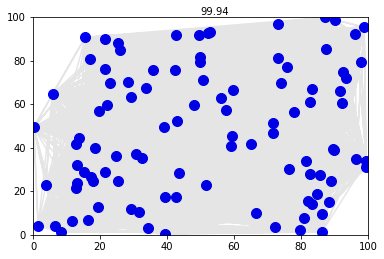

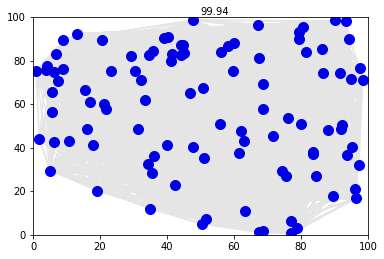

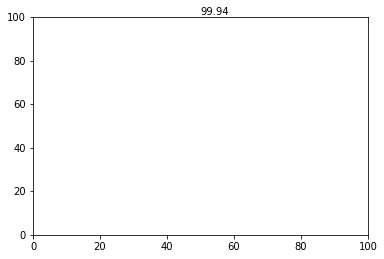

In [87]:
for sim in range(3) :
    print(sim)
    '''returns coordinates, distance matrix, edge_list and the adjacency matrix'''

    dist_mat,coords = calc_dist(N) #node placement

    # edge_list = coupling(dist_mat,circ_rad)
    # edge_list = knn(dist_mat,nn,N)
    # edge_list = rand_network(average_degree,N)
    edge_list = rand_net_gnm(total_edges,N)

    org_adj_mat = np.int64(np.zeros((N,N)))
    for i in range(len(edge_list)):
        org_adj_mat[edge_list[i][0],edge_list[i][1]] = np.int64(1)

    t = np.arange(0,T,dt)
    numpy_array = np.zeros((N,len(t)),dtype = np.int64)
    D_array = np.zeros((N,len(t)))
    adj_mat_list = []
    adj_mat = org_adj_mat
    adj_mat_new = copy.deepcopy(adj_mat)
    adj_mat_list.append(adj_mat_new)

    q = 0
    #coords remain the same. Get new edge_list from the latest adjacency matrix
    edge_list = edge_from_adj_mat(adj_mat_list,q)
    G = networkx_graph(coords,edge_list) #networkx graph

    '''choosing initially infected nodes'''
    indi_state = np.random.randint(1,2,size=(N,1))
    infected_nodes = None
    while infected_nodes is None : #infecting 'start' number of network neighbours
        infected_nodes = InfectNetworkNeighbors(G,np.random.randint(N),start)
        print(infected_nodes)
    infected_nodes = np.asarray(list(infected_nodes)).reshape(len(infected_nodes),1)
    indi_state[infected_nodes[:,0],0] = 2

    A,B = np.meshgrid(indi_state,indi_state)
    partner_state = A
    indi_state_for_rew = B
    # print(indi_state)

    numpy_array [:,0] = indi_state[:,0]

    indi_state_prev = indi_state
    partner_state_prev = partner_state
    indi_state_for_rew_prev = indi_state_for_rew
    # print('indi state =', np.shape(np.transpose(indi_state)))
    # print('partner state =', partner_state)

    d = 999*np.zeros((len(adj_mat),len(adj_mat[0])))

    D = np.zeros((N,1))
    D[np.where(indi_state==2)] = D_ini
    D_array[:,0] = D[:,0]
    D_prev = D

    '''the main part of the simulation'''
    counter = 0
    for t in np.arange(dt,T,dt) :
        q = q + 1    
        counter = counter + 1
        infec_indi = []
        d = np.zeros((len(adj_mat),len(adj_mat[0])))
        d = dose(adj_mat,p,partner_state_prev,d)

        OD_array = np.asarray([val for (node, val) in G.out_degree()])
        OD_mesh1,OD_mesh2 = np.meshgrid(OD_array,OD_array)
        adj_mat = decay(lamb_da,adj_mat,OD_mesh2)
        adj_mat = rew(p_rew,w_minus,adj_mat,indi_state_for_rew_prev)
        adj_mat_new = copy.deepcopy(adj_mat)
        adj_mat_list.append(adj_mat_new)

        #coords remain the same. Get new edge_list from the latest adjacency matrix
        edge_list = edge_from_adj_mat(adj_mat_list,q)
        G = networkx_graph(coords,edge_list) #networkx graph

        D = cumu_dose(d,D_prev,gamma)
        D_array[:,counter] = D[:,0]

        indi_state = upd_indi_state(D,d_star,indi_state_prev)
        numpy_array[:,counter] = indi_state[:,0]
        A,B = np.meshgrid(indi_state,indi_state)

        infec_indi, suscep_indi = states(indi_state)

        partner_state = A
        indi_state_for_rew = B
        indi_state_prev = indi_state
        partner_state_prev = partner_state
        indi_state_for_rew_prev = indi_state_for_rew

        D_prev = D
        D = np.zeros((N,1))

    t = np.arange(0,T,dt,dtype=np.float16)

    '''making the animation'''
    # %matplotlib notebook

    # Set up formatting for the movie files
    Writer = animation.writers['ffmpeg']
    writer = Writer(fps=100, metadata=dict(artist='Me'), bitrate=1800)
    # writer = FasterFFMpegWriter()

    # First set up the figure, the axis, and the plot element we want to animate
    fig = plt.figure()
    ax = plt.axes(xlim=(0, N), ylim=(0, N))
    infected, = ax.plot([], [],'ro', ls='',markersize=10)
    susceptible, = ax.plot([], [],'bo', ls='',markersize=10)
    edges, = ax.plot([],[],'black',alpha=0.1)
    title = ax.text(N/2,N+1,'blah')

    # initialization function: plot the background of each frame
    def init():
        infected.set_data([],[])
        susceptible.set_data([],[])
        return infected,susceptible,

    def init_custom() :
        infected.set_data([],[])
        susceptible.set_data([],[])
        edges.set_data([],[])
        return infected,susceptible,edges,

    # animation function.  This is called sequentially
    def animate(i):
        title.set_text(t[i])
        ix = []
        iy = []
        where = np.transpose(np.where(numpy_array[:,i]==2))
        for k in range(len(where)) : #nodes
            ix.append(coords[where[k][0]][0])
            iy.append(coords[where[k][0]][1])
        infected.set_data(ix, iy)

        sx = []
        sy = []
        where = []
        where = np.transpose(np.where(numpy_array[:,i]==1))
        for k in range(len(where)) : #nodes
            sx.append(coords[where[k][0]][0])
            sy.append(coords[where[k][0]][1])
        susceptible.set_data(sx, sy)

        edge_list = edge_from_adj_mat(adj_mat_list,i)
        ex = []
        ey = []
        j = 0
        for counter in range(len(edge_list)):
            ex.append(coords[edge_list[j][0]][0])
            ex.append(coords[edge_list[j][1]][0])
            ex.append(None)
            ey.append(coords[edge_list[j][0]][1])
            ey.append(coords[edge_list[j][1]][1])
            ey.append(None)
            j = j + 1
        edges.set_data(ex,ey)

        return infected,susceptible,edges,title,

    # call the animator.  blit=True means only re-draw the parts that have changed.
    anim = animation.FuncAnimation(fig, animate, init_func=init_custom,blit=False, save_count=len(t))

    # anim.save('basic_animation.mp4', fps=10, extra_args=['-vcodec', 'libx264'])
    filename = 'sim_'+str(sim)+'_'+str(dataset)+'_'+'.mp4'
    anim.save(filename, writer=writer)

    # plt.show()

# Creating the animation

In [88]:
# plt.clf()
# plt.plot(D_array[4,:])
# plt.show()